## Supervised Learning Series

# Part 1: Linear regression

In this post we formally describe the problem of *linear regression*, or the fitting of a representative line (in higher dimensions) to a set of input/output data points. Regression in general may be performed for a variety of reasons: to produce a so-called trend line (or - more generally - a curve) that can be used to help visually summarize, drive home a particular point about the data under study, or to learn a model so that precise predictions can be made regarding output values in the future.

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import superlearn_library as superlearn
import autograd.numpy as np
import math
import pandas as pd
%matplotlib notebook

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# 1.  Linear regression

With linear regression we aim to fit a line (or hyperplane in higher dimensions) to a scattering of data. In this Section we describe the fundamental concepts underlying this procedure. 

## 1.1  Notation and modeling

Data for regression problems comes in the form of a training set of
$P$ input/output observation pairs

\begin{equation}
 \left(\mathbf{x}_{1},y_{1}\right),\left(\mathbf{x}_{2},y_{2}\right),...,\left(\mathbf{x}_{P},y_{P}\right)
\end{equation}

or $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ for short, where $\mathbf{x}_{p}$ and $y_{p}$ denote the $p^{\textrm{th}}$ input and output respectively. In simple instances the input is scalar-valued (the output will always be considered scalar-valued here) and hence the linear regression problem is geometrically speaking one of fitting a line to the associated scatter of data points in 2-dimensional space.  In general however
each input $\mathbf{x}_{p}$ may be a column vector of length $N$

\begin{equation}
\mathbf{x}_{p}=\left[\begin{array}{c}
x_{1,p}\\
x_{2,p}\\
\vdots\\
x_{N,p}
\end{array}\right].
\end{equation}

in which case the linear regression problem is analogously one of fitting a hyperplane to a scatter of points in $N+1$ dimensional space. 

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_3_1.png' width="100%" height="60%" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em>  A dataset in two dimensions along with a well-fitting line. A line in two dimensions is defined as $w_{0}+xw_{1}=y$, where $w_{0}$ is referred to as the bias and $w_{1}$ the slope, and a point $\left(x_{p},y_{p}\right)$ lies close to it if $w_{0}+x_{p}w_{1}\approx y_{p}$. (right panel) A simulated three dimensional dataset along with a well-fitting hyperplane. A hyperplane is defined as $w_{0}+ x_{1}w_{1} + x_{2}w_{2} + \cdots x_{N}w_{N}=y$, where again $w_{0}$ is called the bias and $w_{1},\,w_{2},\,\cdots \,,w_{N}$ the hyperplanes coordinate wise slopes, and a point $\left(\mathbf{x}_{p},y_{p}\right)$ lies close to it if $w_{0}+ x_{1,p}w_{1} + x_{2,p}w_{2} + \cdots x_{N,p}w_{N} \approx y_{p}$ </em>  </figcaption> 
</figure>

In the case of scalar input the fitting a line to the data (see Figure
\ref{fig:line-and-plane}) requires we determine a slope $w$ and
bias (or ``y-intercept'') $b$ so that the approximate linear relationship
holds between the input/output data

\begin{equation}
w_{0}+x_{p}w_{1}\approx y_{p},\quad p=1,...,P.
\end{equation}

Notice that we have used the \textit{approximately equal} sign in because we cannot be sure
that all data lies completely on a single line.  More generally when the input dimension is $N\geq1$ then we have a bias and $N$ associated slope weights to tune properly in order to fit a hyperplane. Likewise the linear relationship in is then more generally given as

\begin{equation}
w_{0}+ x_{1,p}w_{1} + x_{2,p}w_{2} + \cdots x_{N,p}w_{N} \approx y_{p} ,\quad p=1,...,P.
\end{equation}

For any $N$ we can write the above more compactly via the *inner product* by denoting

\begin{equation}
\mathbf{w}=\left[\begin{array}{c}
w_{0}\\
w_{1}\\
\vdots\\
w_{N}
\end{array}\right]
\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\mathbf{x}_p=\left[\begin{array}{c}
1\\
x_{1,p}\\
\vdots\\
x_{N,p}
\end{array}\right]
\end{equation}

Then we have that the desired relationship is in general

\begin{equation}
\mathbf{x}_{p}^T\mathbf{w} \approx y_{p} ,\quad p=1,...,P.
\end{equation}

The elements of an input vector $\mathbf{x}_{p}$ are referred to as *input features* to a regression problem. For instance the student debt data described in Example has only one feature: *year*. Conversely in the GDP growth rate data described in Example GDP the first element of the input feature vector might contain the feature *unemployment rate* (that is, the unemployment data from each country under study), the second might contain the feature *education level*, and so on. 

#### <span style="color:#a50e3e;">Example 1: </span> Predicting Gross Domestic Product growth rates

As an example of a regression problem with vector-valued input consider the problem of predicting the growth rate of a country's Gross Domestic Product (GDP), which is the value of all goods and services produced within a country during a single year. Economists are often interested in understanding factors (e.g., unemployment rate, education level, population count, land area, income level, investment rate, life expectancy, etc.,) which determine a country's GDP growth rate in order to inform better financial policy making. To understand how these various features of a country relate to its GDP growth rate economists often perform linear regression

In the Figure beow we show a heat map of the world where countries are color-coded based on their GDP growth rate in 2013, reported by the International Monetary Fund (IMF) (data from this Figure was taken from [1]).

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_3_2.png' width="70%" height="60%" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em>  A map of the world where countries are color-coded by their GDP growth rates (the darker color the higher the growth rate) as reported by the International Monetary Fund (IMF) in 2013.  </em>  </figcaption> 
</figure>

## 1.2  The Least Squares cost function

To find the parameters of the hyperplane which best fits a regression dataset, it is common practice to first form the *Least Squares cost function*. For a given set of parameters $\mathbf{w}$ this cost function computes the total squared error between the associated hyperplane and the data (as illustrated pictorially in Figure \ref{fig:regression-error-illustrated}), giving a good measure of how well the particular linear model fits
the dataset. Naturally then the best fitting hyperplane is the one whose parameters minimize this error.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_3_3.png' width="50%" height="50%" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em>  A simulated two dimensional training dataset along with a line (in magenta) fit to the data using the Least Squares framework, which aims at recovering the line that minimizes the total squared length of the dashed error bars.  </em>  </figcaption> 
</figure>

We want to find a weight vector $\mathbf{w}$ so that each of $P$ approximate equalities in equation (6) holds as well as possible.  Notice another way of saying that $\mathbf{x}_{p}^T\mathbf{w} \approx y_{p}$ - meaning that the approximation "$\approx$" is as close to an equality "$=$" as possible - is to say that the *error* between $\mathbf{x}_{p}^{T}\mathbf{w}$ and $y_{p}$ is small.  One natural way to measure error between two quantities like this is simply to square their difference as 

\begin{equation}
\left(\mathbf{x}_{p}^{T}\mathbf{w} - y_{p}^{\,}\right)^2
\end{equation}

Since we want all $P$ such values to be small we can sum them up - forming a *Least Squares* cost function

\begin{equation}
\,g\left(\mathbf{w}\right)=\sum_{p=1}^{P}\left(\mathbf{x}_{p}^{T}\mathbf{w}-y_{p}^{\,}\right)^{2}
\end{equation}

In particular, it is the *Least Squares cost function for linear regression*.

We want to find a parameter pair $\mathbf{w}$ that provides a small value for $g\left(\mathbf{w}\right)$ since the larger this value becomes the larger the squared error between the corresponding linear model and the data, the worse the $p^{th}$ approximation becomes, and hence the poorer we represent the given dataset using a linear model. In other words, we want to determine a value for $\mathbf{w}$ that *minimizes* $g(\mathbf{w})$, or written formally we want to solve the unconstrained problem

\begin{equation}
\underset{\mathbf{w}}{\mbox{minimize}}\,\,\underset{p=1}{\overset{P}{\sum}}\left(\mathbf{x}_{p}^{T}\mathbf{w}-y_{p}^{\,}\right)^{2}.
\end{equation}

## 1.3  Minimization of the Least Squares cost function

As discussed in our *mathematical optimization series*, generally speaking determining the overall shape of a function - i.e., whether or not a function is convex - helps determine the appropriate optimization method(s) we can apply to effeciently determine the ideal $\mathbf{w}$.  In the case of the Least Squares cost function for linear regression it is easy to check that *the cost function is always convex regardless of the dataset*.  

For small input dimensions (i.e., $N=1$ or $N=2$) we can empirically verify this claim for any given dataset by simply plotting the function $g(\mathbf{w})$ - as a surface and/or contour plot - as we do in the example below.

#### <span style="color:#a50e3e;">Example 2: </span> Visually verifying the convexity of the cost function for the student loan dataset

In [13]:
datapath = '../../mlrefined_datasets/superlearn_datasets/student_debt.csv'
data = np.asarray(pd.read_csv(datapath,header = None))

In [14]:
demo = superlearn.lin_regression_demos.visualizer(data)

<IPython.core.display.Javascript object>


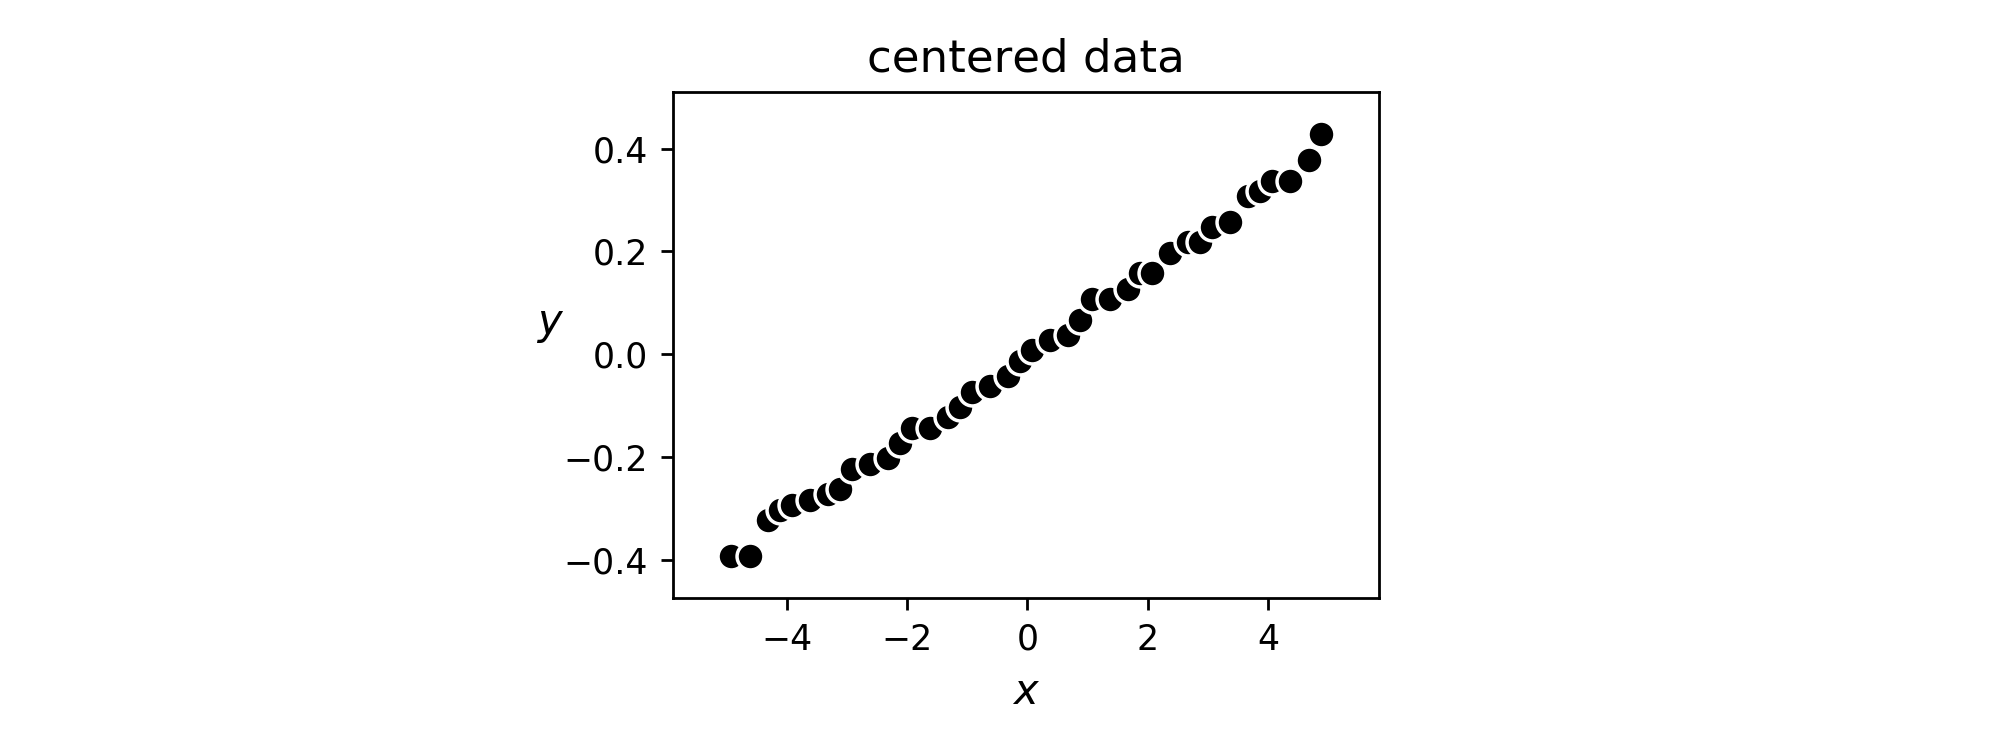

In [15]:
demo.plot_data()

<IPython.core.display.Javascript object>


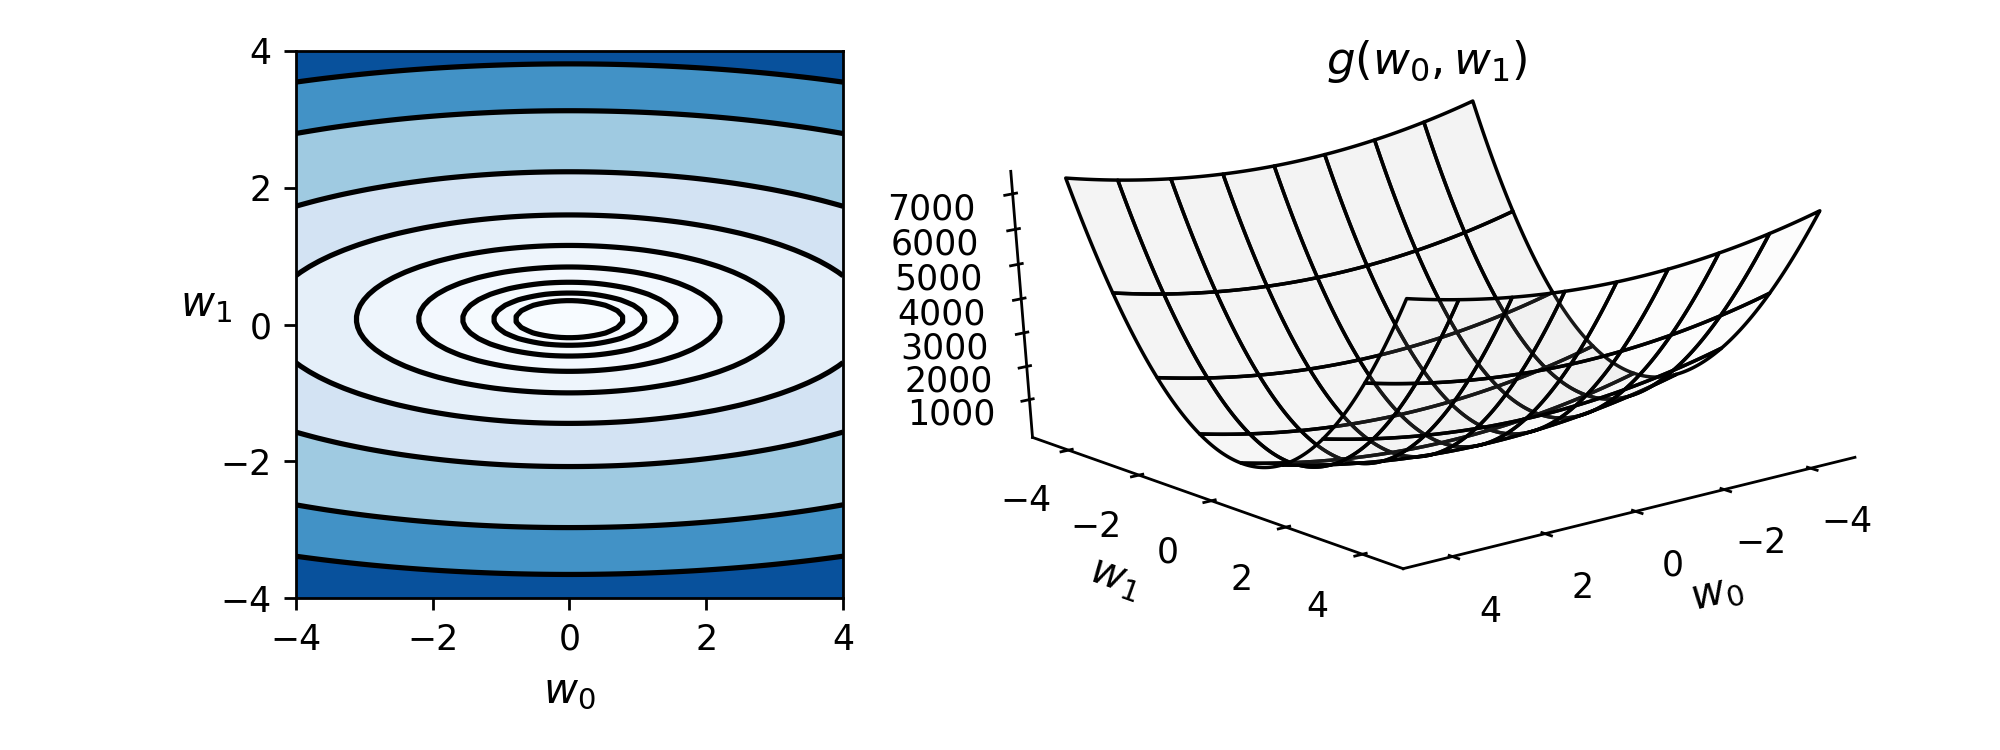

In [21]:
demo.plot_ls_cost(view = [30,50],wmax = 4,num_contours = 25)

For example, in the figure below we plot Least Squares cost function for linear regression associated with the student loan dataset in EXAMPLE, whose 'upward bending' shape confirms its convexity.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_3_4.png' width="50%" height="50%" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> 
    <em>  The surface generated by the Least Squares cost function using the student loan debt data shown in Figure [fig:student-debt-regression], is clearly convex. However regardless of the dataset, the Least Squares cost for linear regression is always convex.   </em>  </figcaption> 
</figure>

However the Least Squares cost function for linear regression can be mathematically shown to be  - in general - a *convex function*.  Because of this we can directly apply either gradient descent (and in particular the *unnormalized* form) or Newton's method in order to minimize it. 

> The Least Squares cost function for linear regression is always convex, hence we can easily apply either gradient descent or Newton's method in order to minimize it.

The generic practical considerations associated with each method still exist here (see ouor Mathematical Optimization Series): i.e., with gradient descent we must choose a steplength scheme, and Newton's method is practically limited to cases when $N$ is of moderate value (e.g., in the thousands).  For the case of gradient descent we can use a fixed steplength value (and indeed can compute a conservative Lipschitz value that will always produce descent), a diminishing steplength scheme, or an adjustable method like backtracking line search.

#### <span style="color:#a50e3e;">Example 2: </span> Using gradient descent to fit the student debt dataset

In [64]:
datapath = '../../mlrefined_datasets/superlearn_datasets/2d_linregress_data.csv'
data = np.asarray(pd.read_csv(datapath,header = None))

In [65]:
demo = superlearn.lin_regression_demos.visualizer(data)

In [79]:
demo.run_algo(algo = 'gradient_descent',w_init = [1.5,-2], max_its = 70,alpha = 0.01)


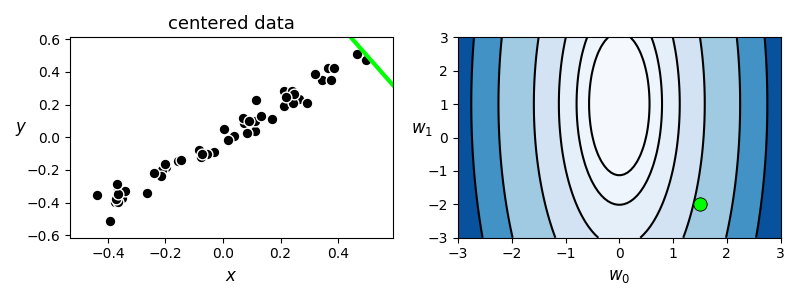
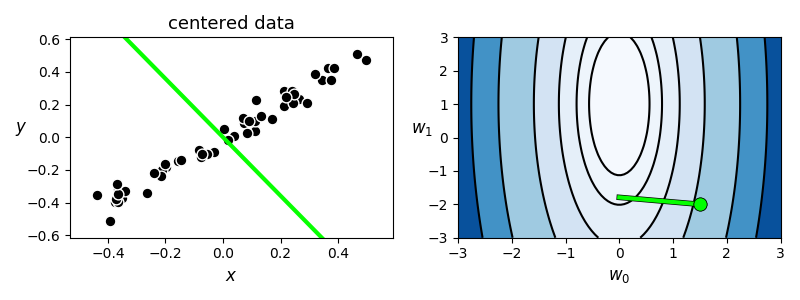
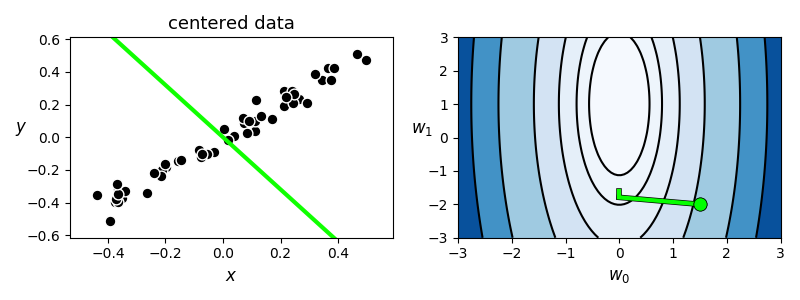
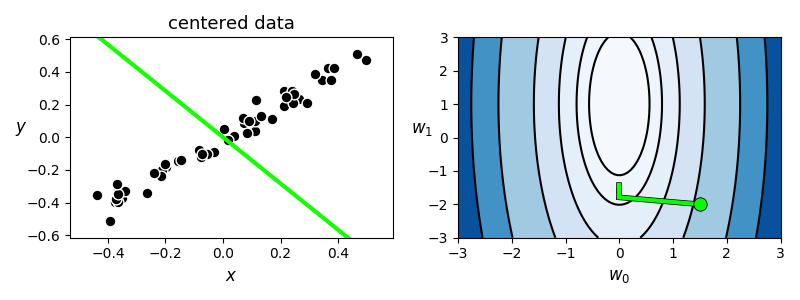
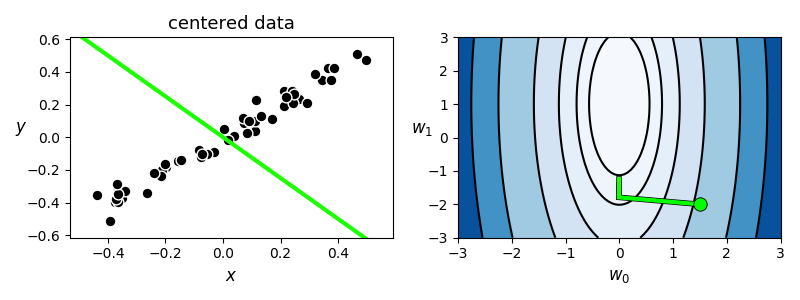
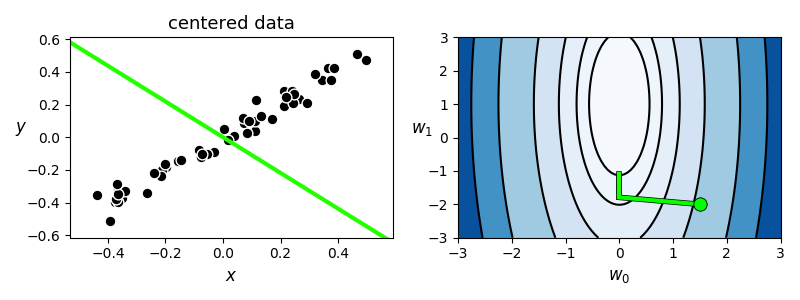
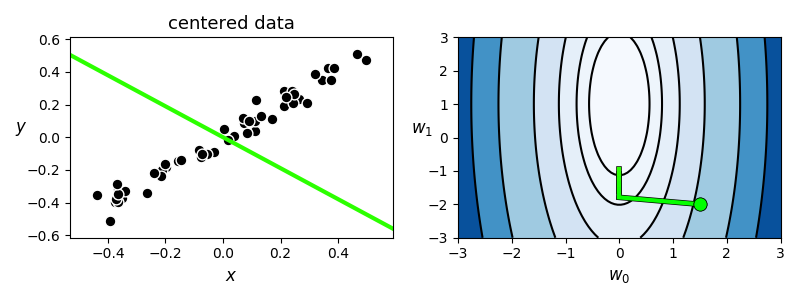
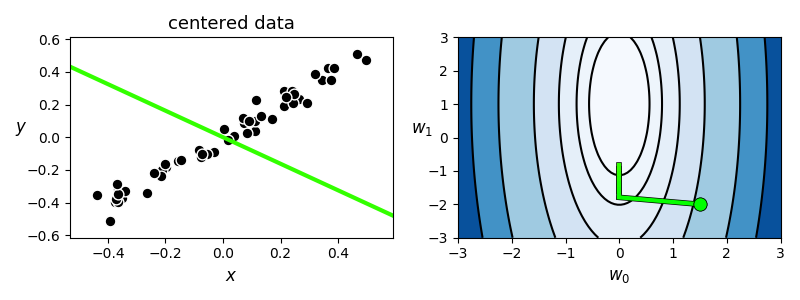
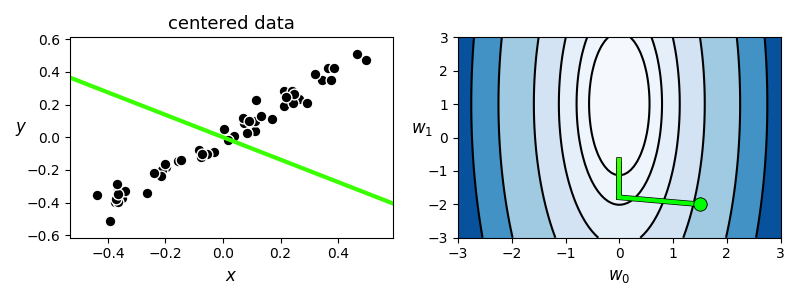
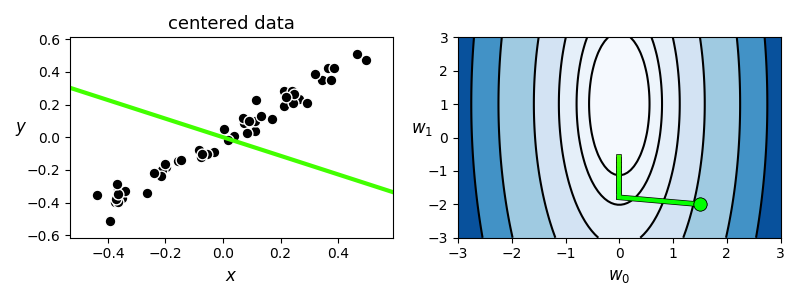
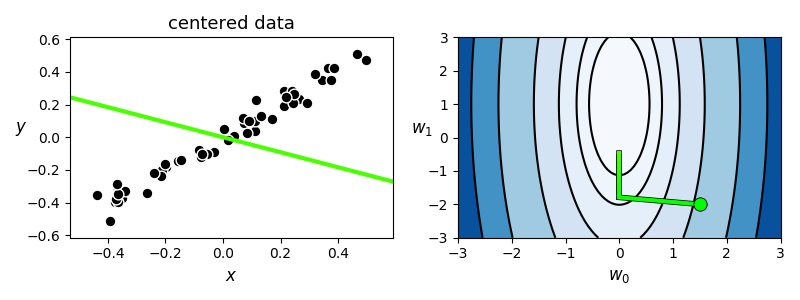
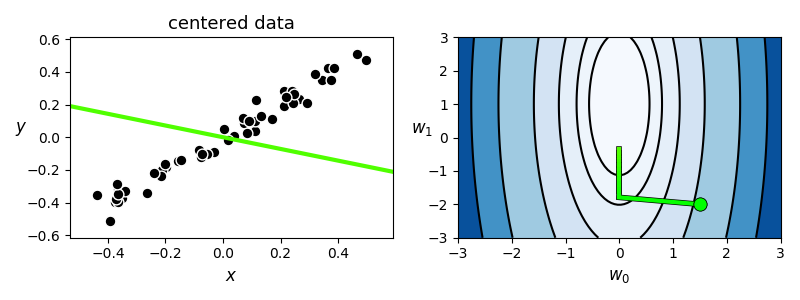
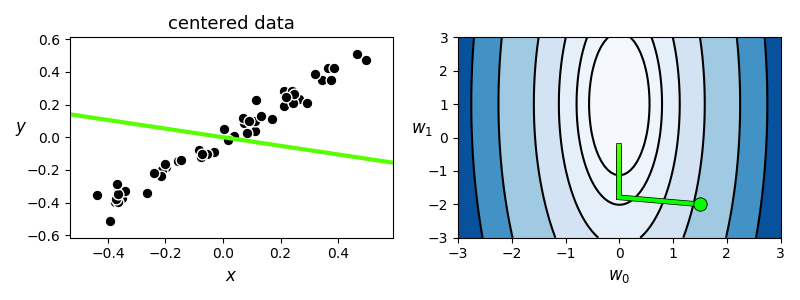
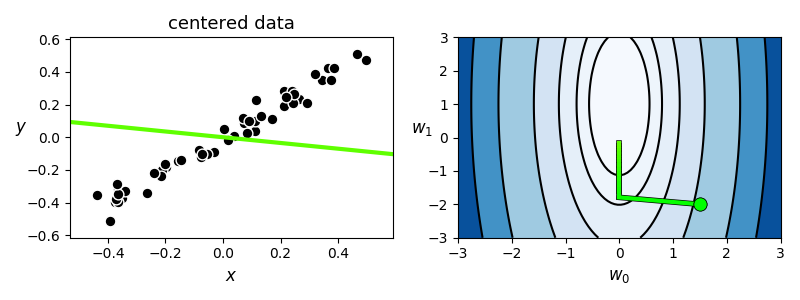
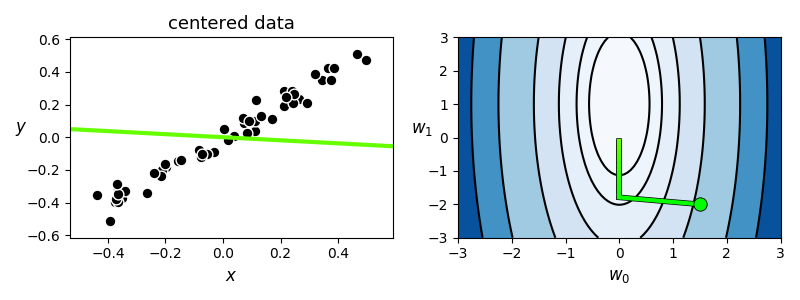
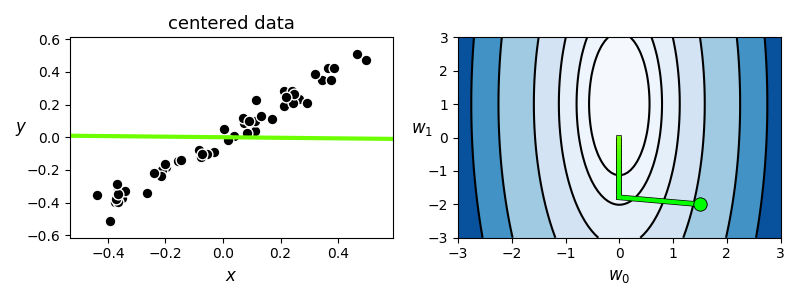
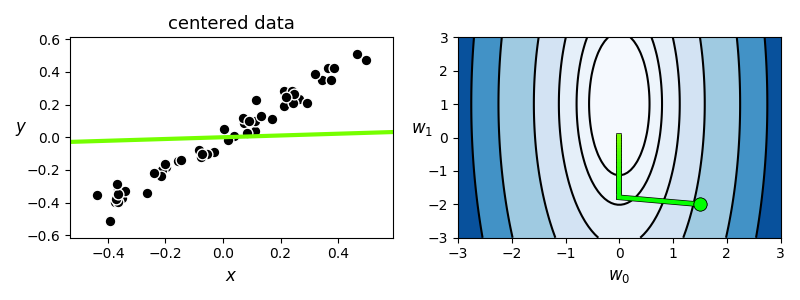
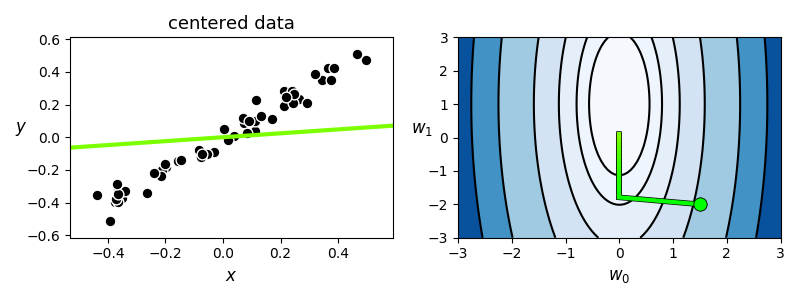
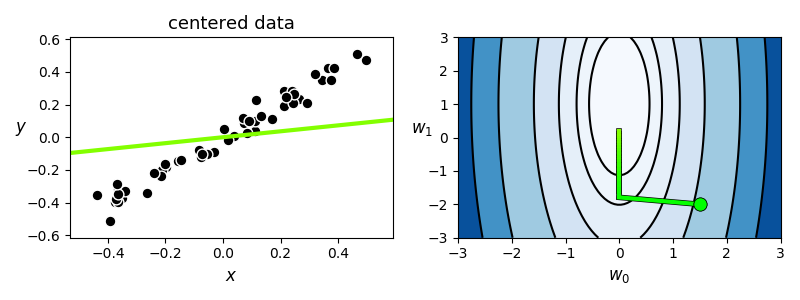
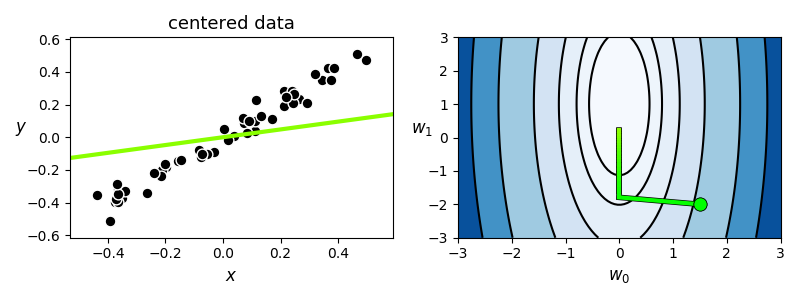
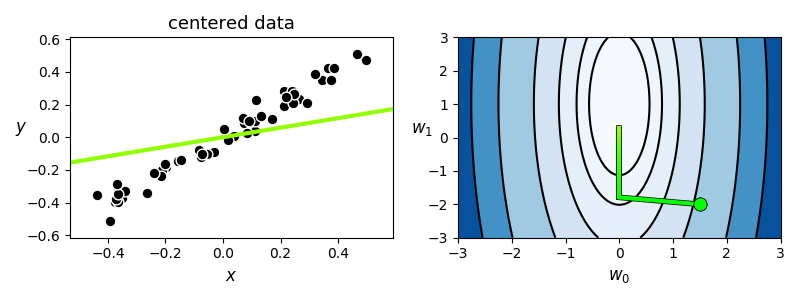
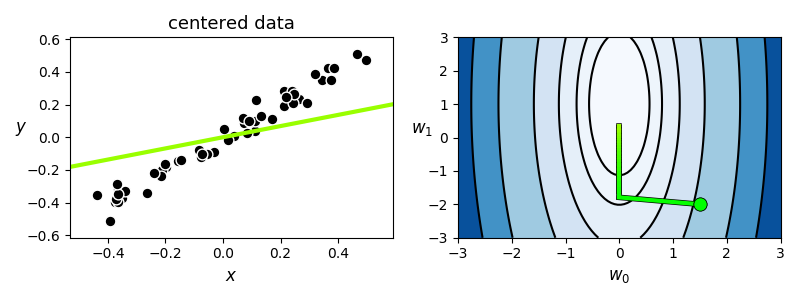
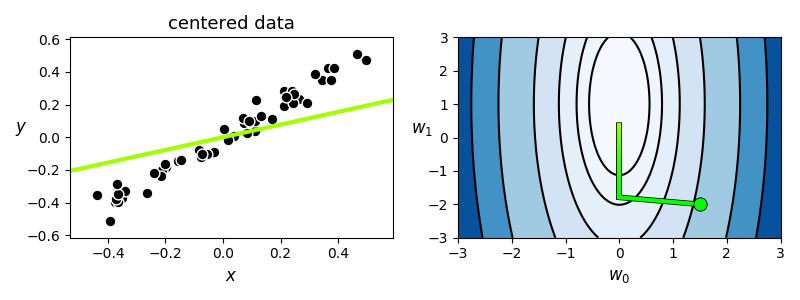
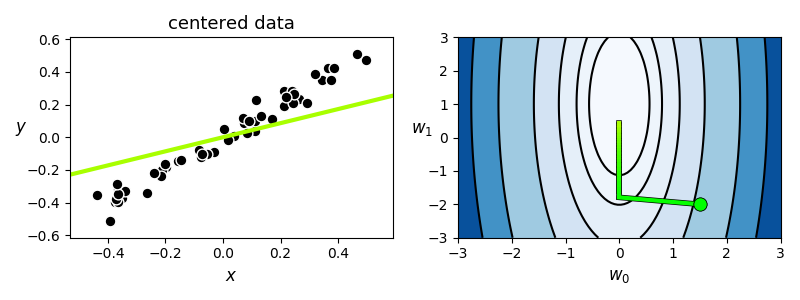
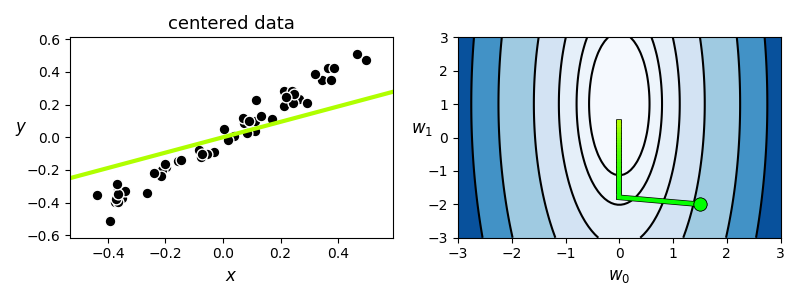
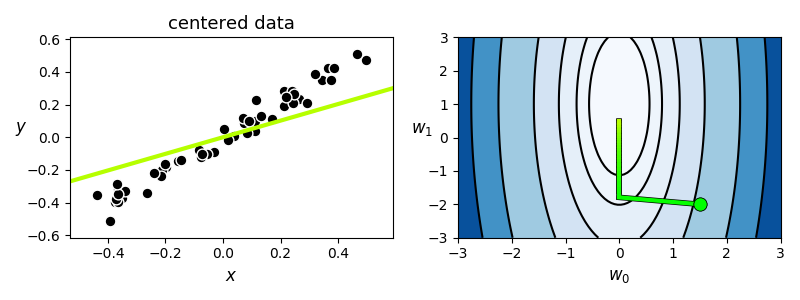
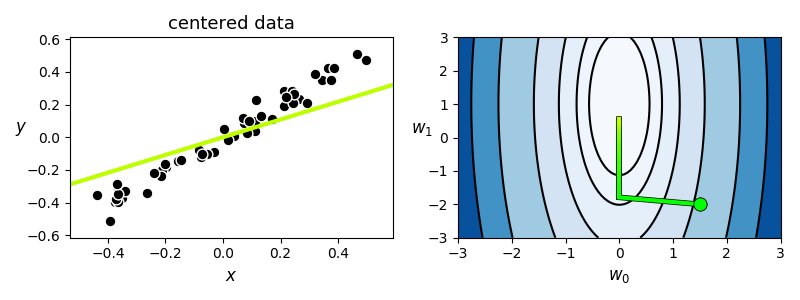
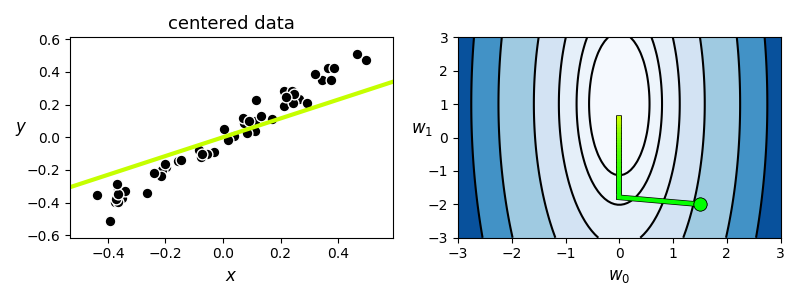
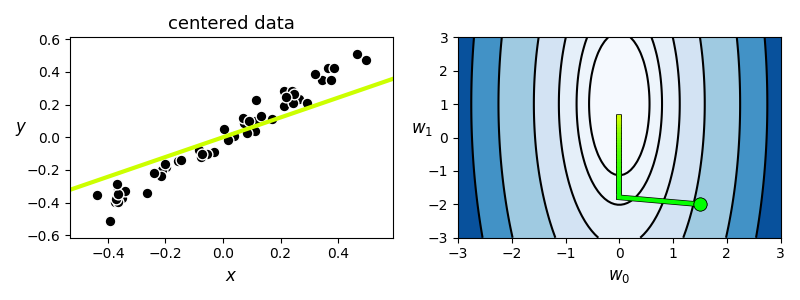
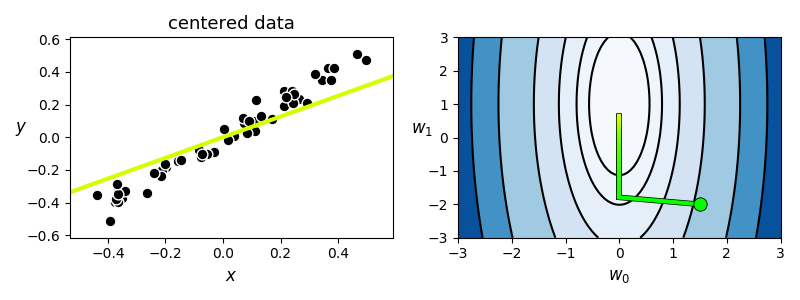
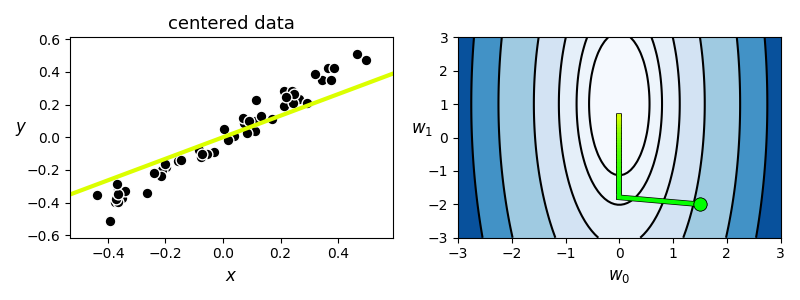
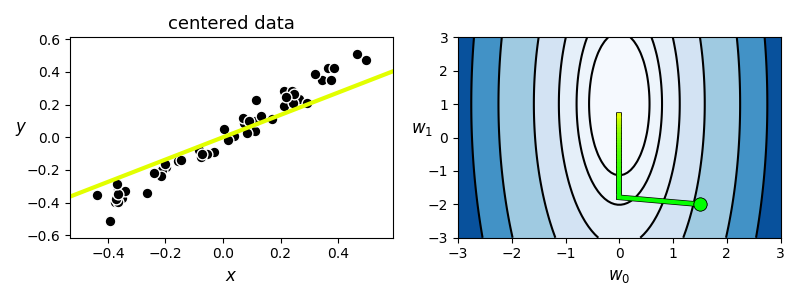
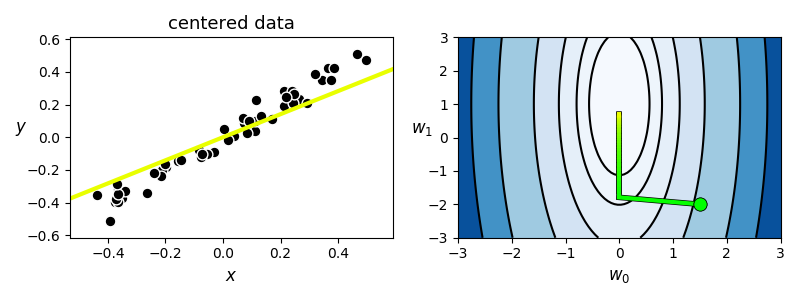
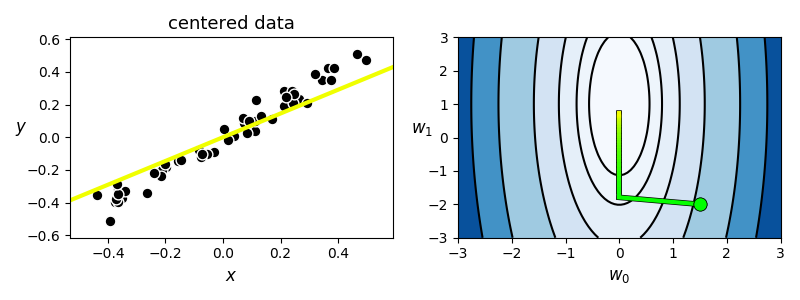
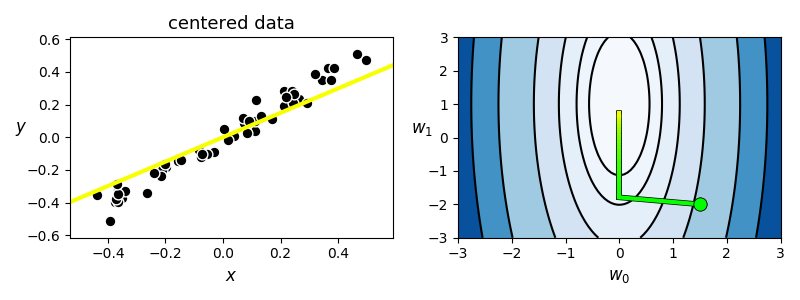
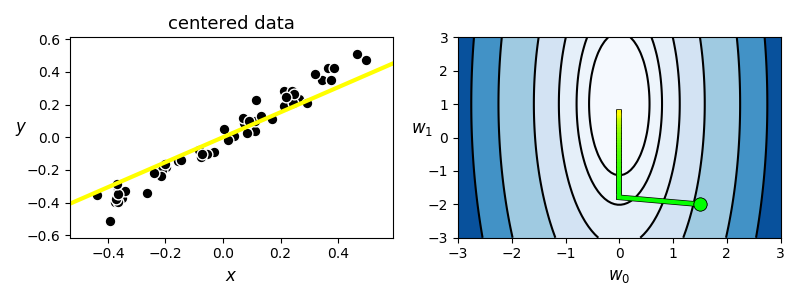
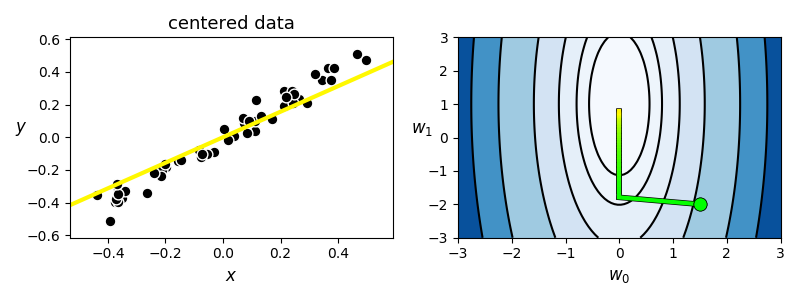
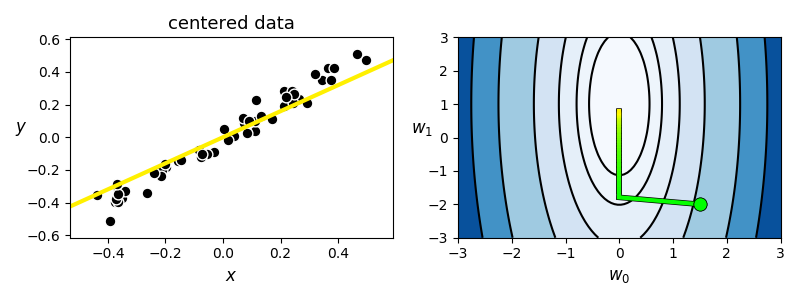
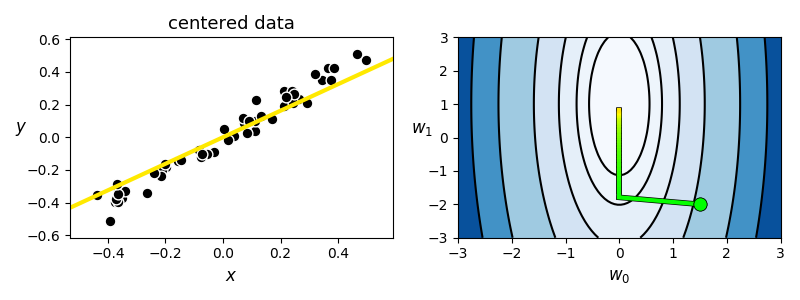
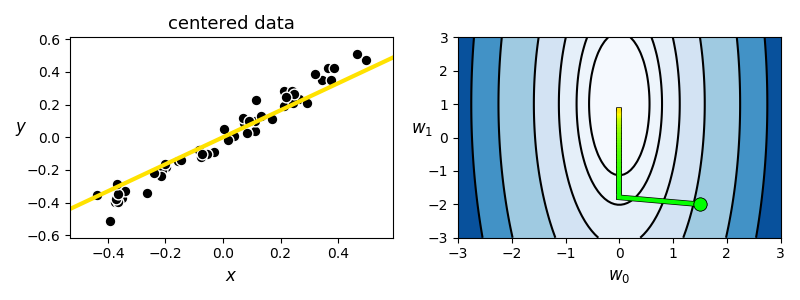
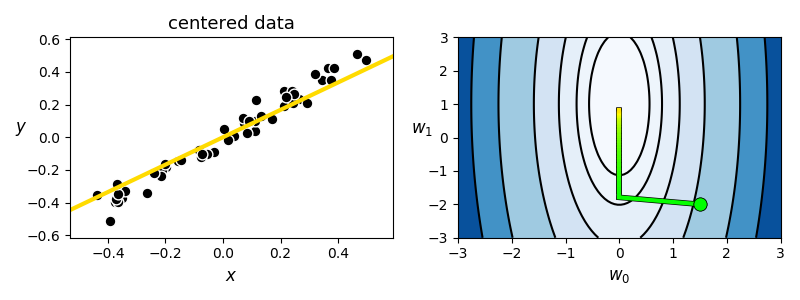
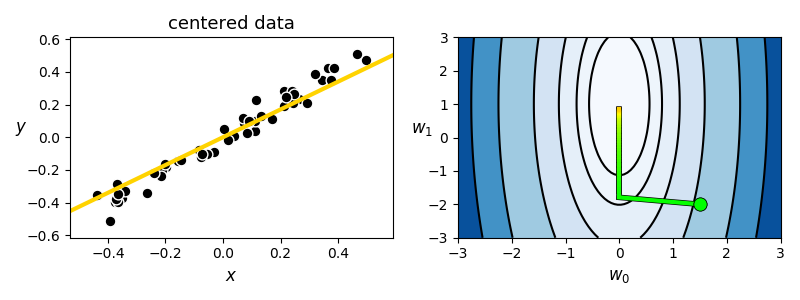
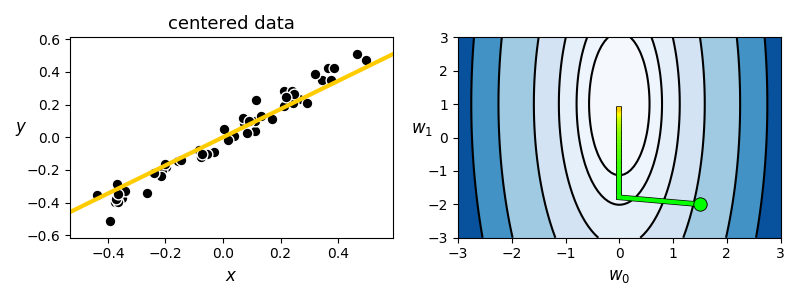
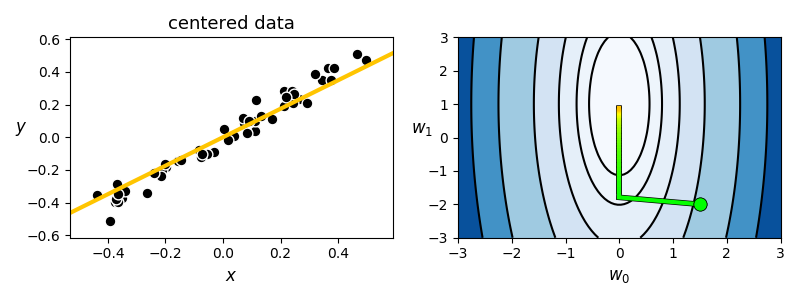
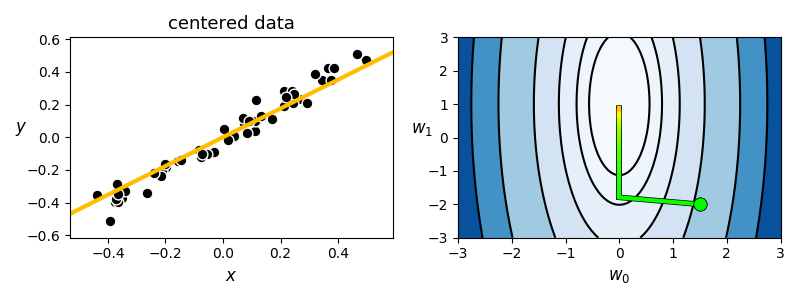
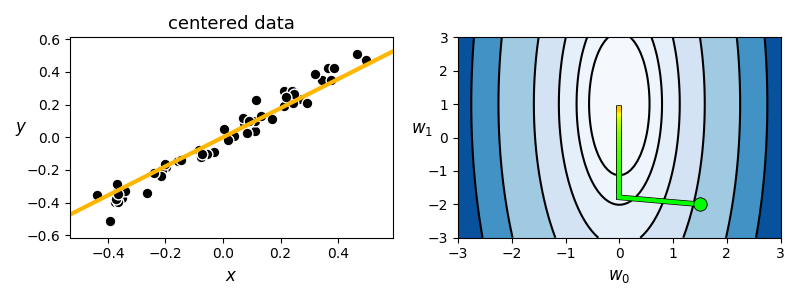
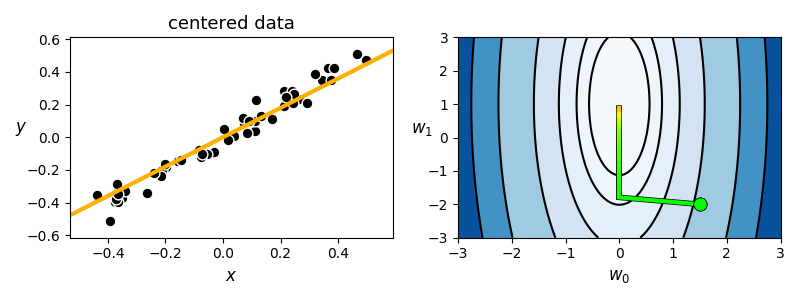
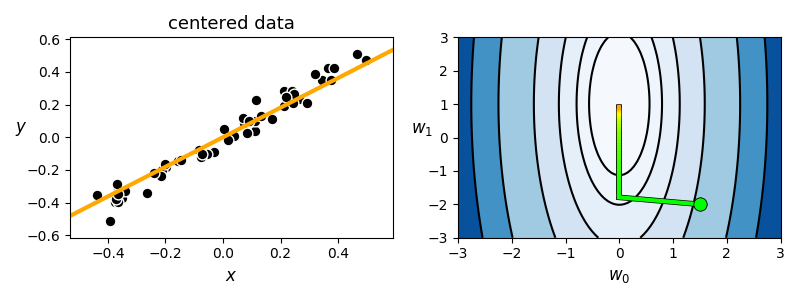
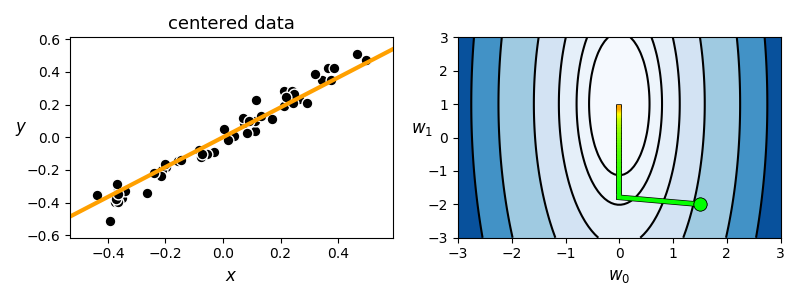
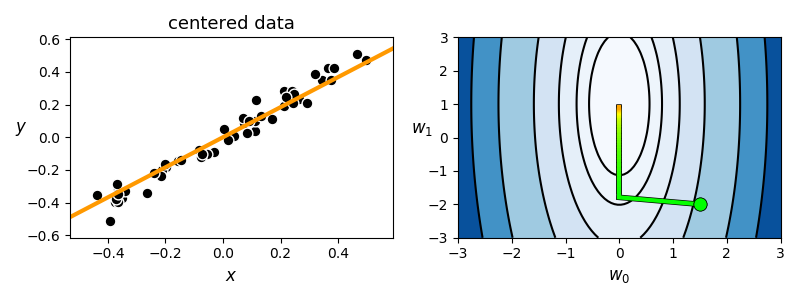
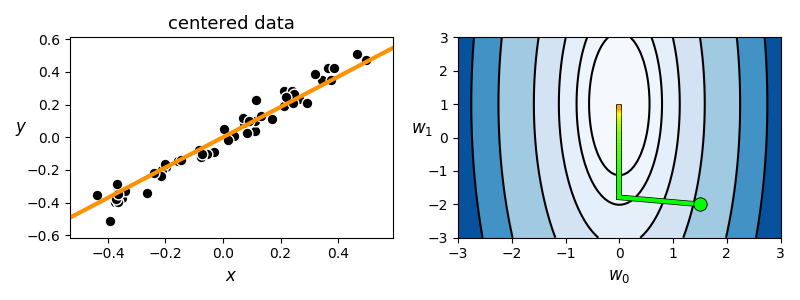
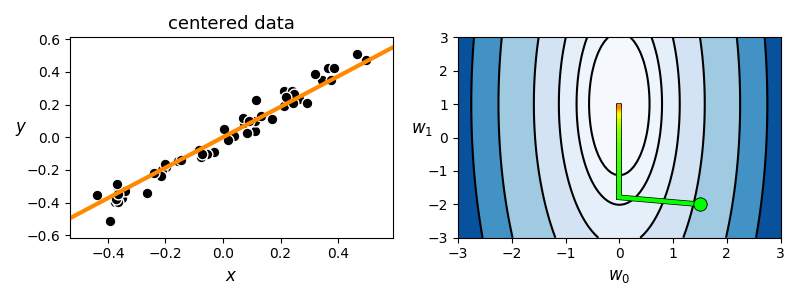
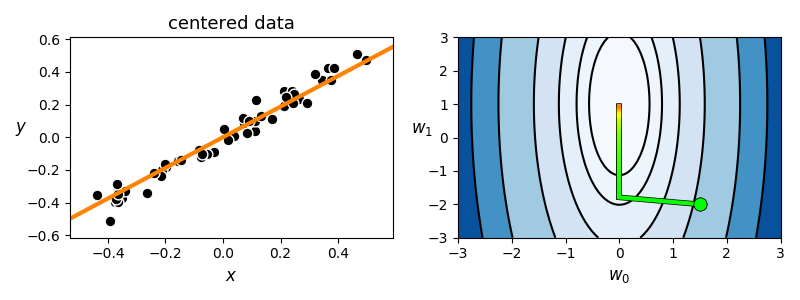
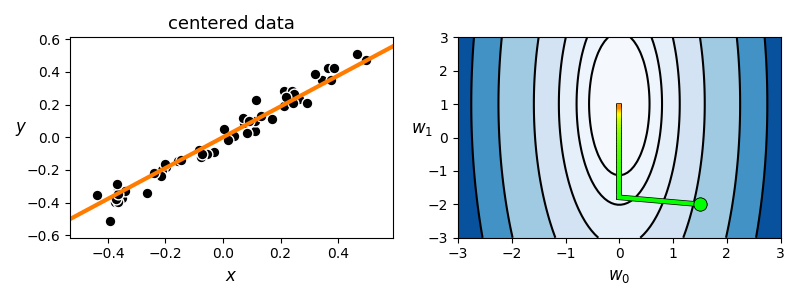
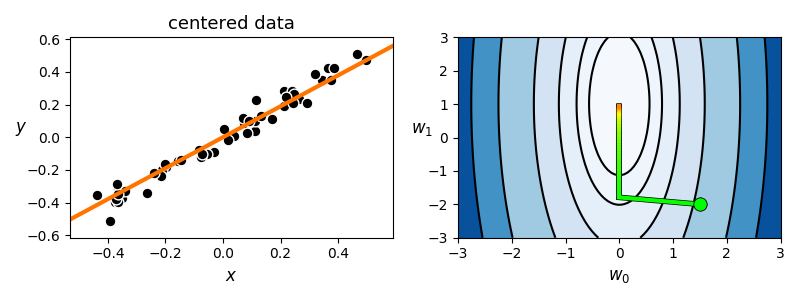
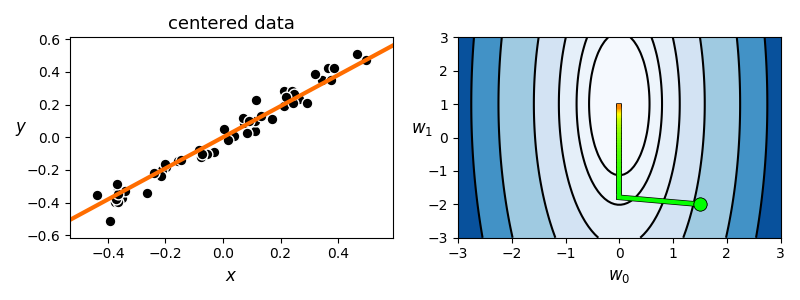
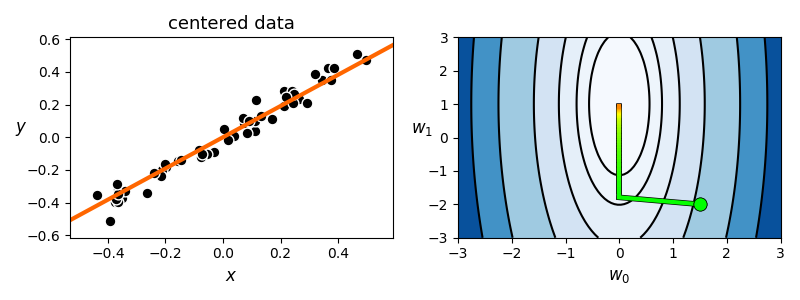
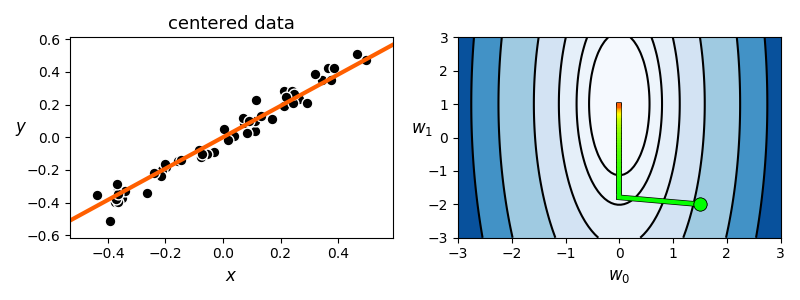
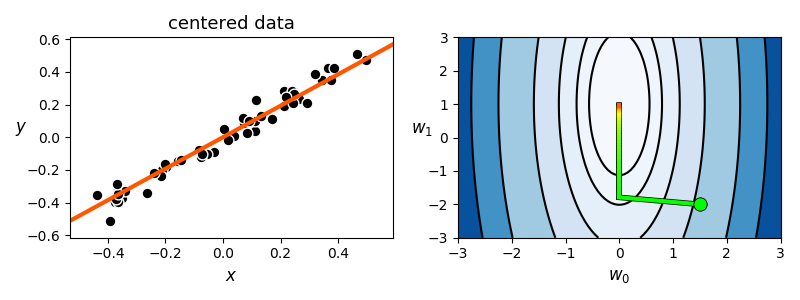
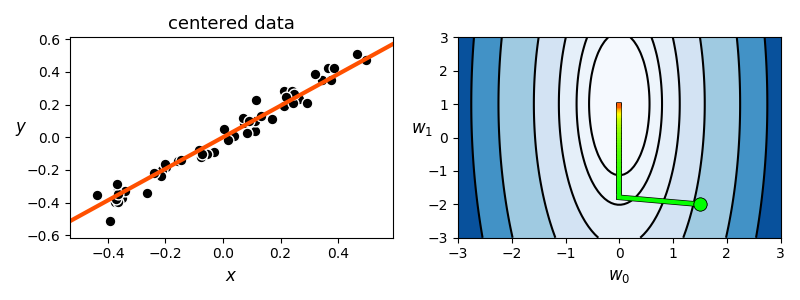
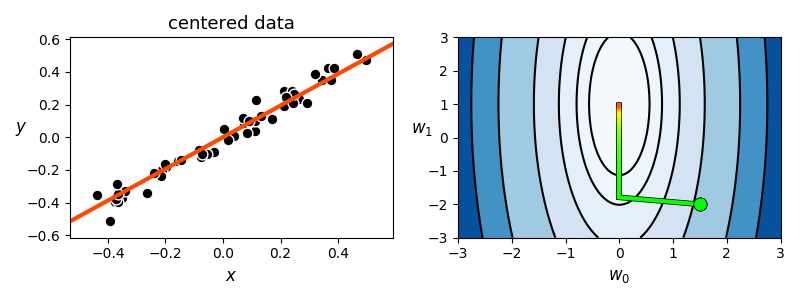
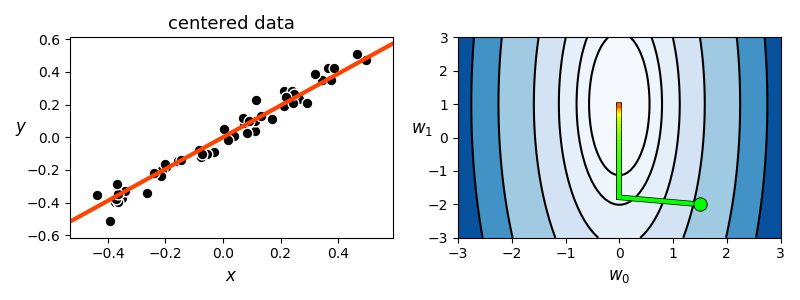
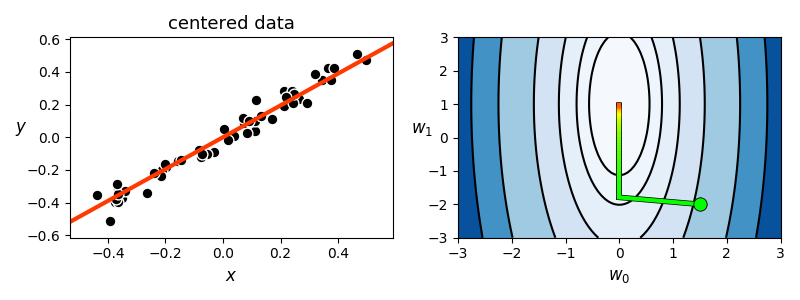
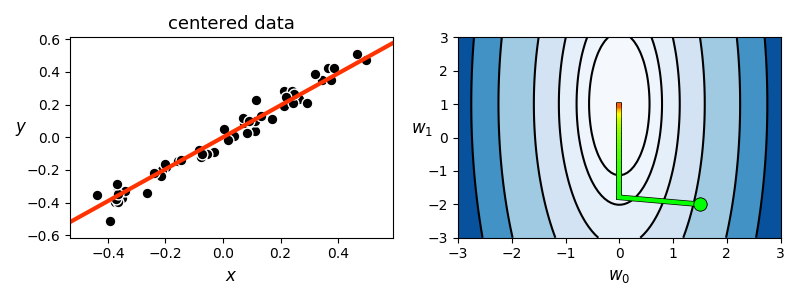
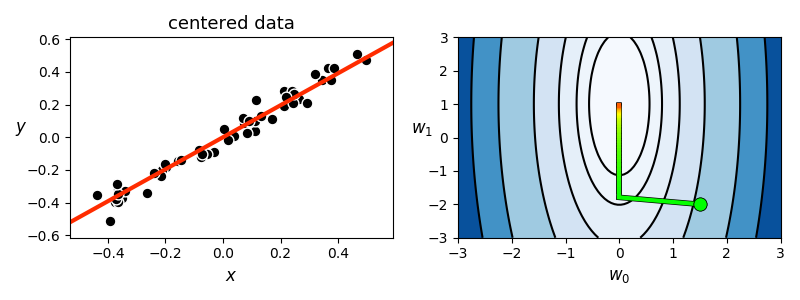
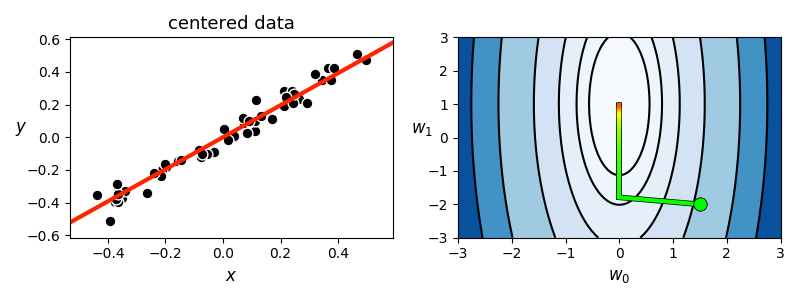
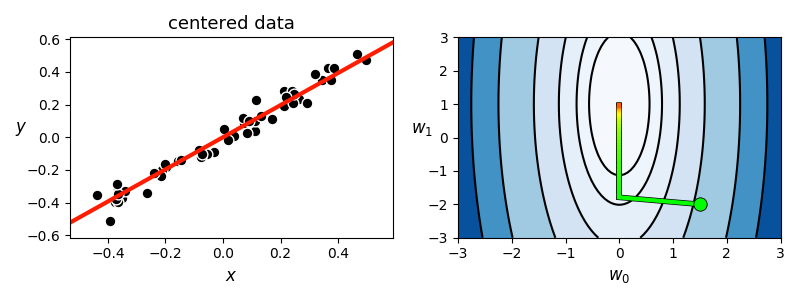
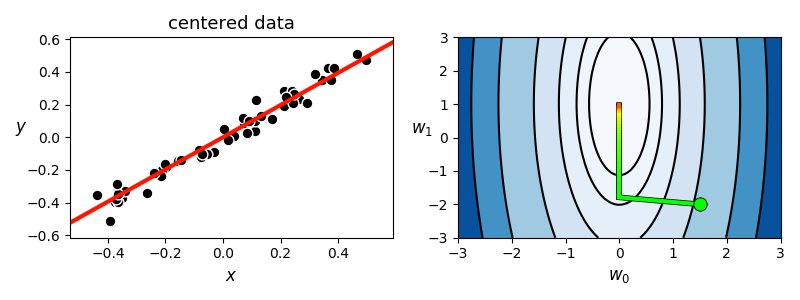
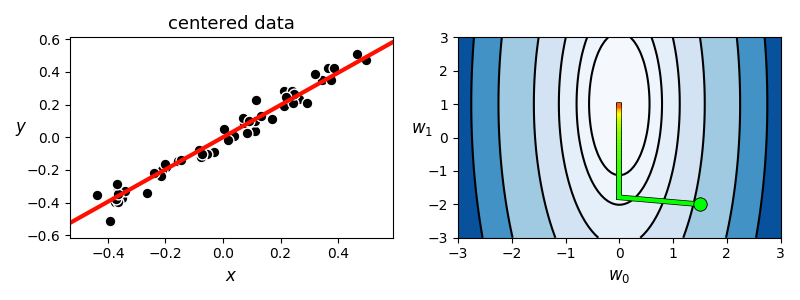
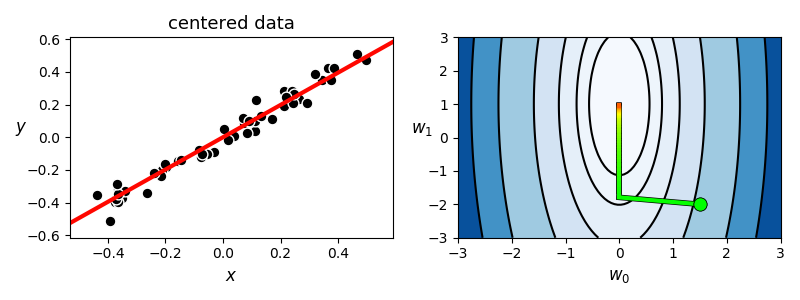
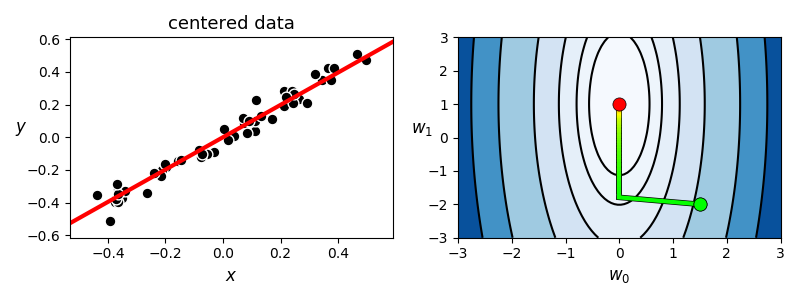

In [80]:
demo.animate_it(view = [10,30])

In [42]:
# what function should we play with?  Defined in the next line.
g = lambda w: w[0]**2 + 5*w[1]**2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.convservative_steplength_demos.visualizer();
w_init = [2,0.5]; max_its = 10; steplength_vals = ['backtracking',0.1];

demo.run(g,w_init,steplength_vals,max_its,version = 'unnormalized',num_contours = 30,xmin = -1, xmax = 2.1, ymin = -0.75, ymax = 0.75)

NameError: name 'optlib' is not defined

## 1.4  The efficacy of a learned model

## 1.5 Predicting the value of new input data

## 1.6 Appendix

## Proof of convexity of the Least Squares cost with linear model

- take from ed1 chapter 8 appendix

## Proof of Lipschitz constant

- take from ed1 chapter 8 appendix